In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipinfo
import json
from tqdm import tqdm

from category_encoders.hashing import HashingEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [3]:
data = pd.read_csv('Darknet.csv', low_memory=False, error_bad_lines=False)
data.head()

c:\Users\seung hyeon Jeon\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 328: expected 85 fields, saw 125\n'


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
0,10.152.152.11-216.58.220.99-57158-443-6,10.152.152.11,57158,216.58.220.99,443,6,24/07/2015 04:09:48 PM,229,1,1,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
1,10.152.152.11-216.58.220.99-57159-443-6,10.152.152.11,57159,216.58.220.99,443,6,24/07/2015 04:09:48 PM,407,1,1,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
2,10.152.152.11-216.58.220.99-57160-443-6,10.152.152.11,57160,216.58.220.99,443,6,24/07/2015 04:09:48 PM,431,1,1,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
3,10.152.152.11-74.125.136.120-49134-443-6,10.152.152.11,49134,74.125.136.120,443,6,24/07/2015 04:09:48 PM,359,1,1,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
4,10.152.152.11-173.194.65.127-34697-19305-6,10.152.152.11,34697,173.194.65.127,19305,6,24/07/2015 04:09:45 PM,10778451,591,400,...,0,0,0,0,1.437765e+15,3.117718e+06,1.437765e+15,1.437765e+15,Non-Tor,AUDIO-STREAMING


In [4]:
samples = data.copy()

In [5]:
traffic_labels = samples["Label"].unique()
print(traffic_labels)
traffic_type_labels = samples["Label.1"].unique()
print(traffic_type_labels)

['Non-Tor' 'NonVPN' 'Tor' 'VPN']
['AUDIO-STREAMING' 'Browsing' 'Chat' 'Email' 'File-Transfer'
 'File-transfer' 'P2P' 'Video-Streaming' 'Audio-Streaming'
 'Video-streaming' 'VOIP']


In [6]:
samples['Label.1'].loc[samples['Label.1'] == 'AUDIO-STREAMING'] = 'Audio-Streaming'
samples['Label.1'].loc[samples['Label.1'] == 'File-transfer'] = 'File-Transfer'
samples['Label.1'].loc[samples['Label.1'] == 'Video-streaming'] = 'Video-Streaming'

traffic_type_labels = samples["Label.1"].unique()
print(traffic_type_labels)

['Audio-Streaming' 'Browsing' 'Chat' 'Email' 'File-Transfer' 'P2P'
 'Video-Streaming' 'VOIP']


c:\Users\seung hyeon Jeon\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [7]:
samples['Label'].loc[(samples['Label'] == 'Non-Tor') | (samples['Label'] == 'NonVPN')] = 'Clearnet'
samples['Label'].loc[(samples['Label'] == 'Tor') | (samples['Label'] == 'VPN')] = 'Darknet'

traffic_labels = samples["Label"].unique()
print(traffic_labels)

['Clearnet' 'Darknet']


In [8]:
hours = []
for timestamp in samples['Timestamp']:
    hora = int(timestamp.split()[1].split(':')[0])
    hours.append(hora)
samples['hour'] = hours
print(samples[['Timestamp', 'hour']][:5])

                Timestamp  hour
0  24/07/2015 04:09:48 PM     4
1  24/07/2015 04:09:48 PM     4
2  24/07/2015 04:09:48 PM     4
3  24/07/2015 04:09:48 PM     4
4  24/07/2015 04:09:45 PM     4


In [9]:
def create_grams(ip):
    parts = ip.split('.')
    one_gram = parts[0]
    two_gram = parts[0] + " " + parts[1]
    three_gram = parts[0] + " " + parts[1] + " " + parts[2]
    return one_gram, two_gram, three_gram

In [10]:
src_one_gram = []
src_two_gram = []
src_three_gram = []
dst_one_gram = []
dst_two_gram = []
dst_three_gram = []

for src_ip, dst_ip in zip(samples["Src IP"], samples["Dst IP"]): 
    src_one, src_two, src_three = create_grams(src_ip)
    src_one_gram.append(src_one)
    src_two_gram.append(src_two)
    src_three_gram.append(src_three)
    dst_one, dst_two, dst_three = create_grams(dst_ip)
    dst_one_gram.append(dst_one)
    dst_two_gram.append(dst_two)
    dst_three_gram.append(dst_three)

samples["src_ip_1gram"] = src_one_gram
samples["src_ip_2gram"] = src_two_gram
samples["src_ip_3gram"] = src_three_gram

samples["dst_ip_1gram"] = dst_one_gram
samples["dst_ip_2gram"] = dst_two_gram
samples["dst_ip_3gram"] = dst_three_gram

In [11]:
print(samples[["Src IP","src_ip_1gram","src_ip_2gram","src_ip_3gram"]][200:205])
print(samples[["Dst IP","dst_ip_1gram","dst_ip_2gram","dst_ip_3gram"]][:5])

            Src IP src_ip_1gram src_ip_2gram src_ip_3gram
200  10.152.152.11           10       10 152   10 152 152
201  74.125.28.189           74       74 125    74 125 28
202  74.125.28.189           74       74 125    74 125 28
203  10.152.152.11           10       10 152   10 152 152
204  10.152.152.11           10       10 152   10 152 152
           Dst IP dst_ip_1gram dst_ip_2gram dst_ip_3gram
0   216.58.220.99          216       216 58   216 58 220
1   216.58.220.99          216       216 58   216 58 220
2   216.58.220.99          216       216 58   216 58 220
3  74.125.136.120           74       74 125   74 125 136
4  173.194.65.127          173      173 194   173 194 65


In [12]:
def get_ip_detail(ip, ip_dict, repeated):
    if ip not in ip_dict.keys():
        details = ipinfo_handler.getDetails(ip)
        ip_dict[ip] = details.all
    else:
        repeated += 1
    return repeated

def dump_ips(ip_dict, folder):
    j = json.dumps(ip_dict)
    f = open(folder+"ips_dict.json","w")
    f.write(j)
    f.close()

def load_ips(file):
    data = {}
    with open(file) as json_file:
        data = json.load(json_file)
    return data

In [13]:
ip_dict = load_ips("ips_dict.json")

In [14]:
ips = np.concatenate((samples["Src IP"].unique(), samples["Dst IP"].unique())) 
for i in tqdm(range(len(ips))):
    get_ip_detail(ips[i], ip_dict, 0)
dump_ips(ip_dict, "")

100%|██████████| 11111/11111 [00:00<00:00, 1591357.75it/s]


In [15]:
ips_tuple = zip(samples["Src IP"], samples["Dst IP"])
dst_ip_country = []
src_ip_country = []
src_bogon = []
dst_bogon = []

for src_ip, dst_ip in tqdm(ips_tuple, total=len(samples["Src IP"])):
    if 'country' in ip_dict[dst_ip].keys():
        dst_ip_country.append(ip_dict[dst_ip]['country'])
    else:
        dst_ip_country.append("")
    if 'country' in ip_dict[src_ip].keys():
        src_ip_country.append(ip_dict[src_ip]['country'])
    else:
        src_ip_country.append("")
    if 'bogon' in ip_dict[dst_ip].keys():
        dst_bogon.append(ip_dict[dst_ip]['bogon'])
    else:
        dst_bogon.append(False)
    if 'bogon' in ip_dict[src_ip].keys():
        src_bogon.append(ip_dict[src_ip]['bogon'])
    else:
        src_bogon.append(False)
samples['src_ip_country'] = src_ip_country
samples['dst_ip_country'] = dst_ip_country
samples['src_bogon'] = src_bogon
samples['dst_bogon'] = dst_bogon

100%|██████████| 141530/141530 [00:00<00:00, 810773.32it/s]


In [16]:
real_columns = ['Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg', 'Bwd Packet/Bulk Avg', 'Bwd Bulk Rate Avg', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'FWD Init Win Bytes', 'Bwd Init Win Bytes', 'Fwd Act Data Pkts', 'Fwd Seg Size Min']
print(real_columns)

['Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average

In [17]:
is_na_cols = samples.columns[samples.isna().sum() > 0]
samples.isna().sum()[is_na_cols] 

Flow Bytes/s    47
dtype: int64

In [18]:
samples = samples.dropna()
samples.isna().sum()[is_na_cols] 

Flow Bytes/s    0
dtype: int64

In [19]:
samples[real_columns] = samples[real_columns].astype(np.float64)
samples[real_columns] = samples[real_columns].replace([np.inf, -np.inf], np.nan)
samples[real_columns] = samples[real_columns].dropna()

In [20]:
model_samples = samples.copy()

del model_samples['Flow ID']
del model_samples['Timestamp']
del model_samples['Src IP']
del model_samples['Dst IP']

In [21]:
cols = np.concatenate((model_samples.columns[81:], model_samples.columns[:81]))
model_samples = model_samples[cols]

In [22]:
model_samples.columns

Index(['hour', 'src_ip_1gram', 'src_ip_2gram', 'src_ip_3gram', 'dst_ip_1gram',
       'dst_ip_2gram', 'dst_ip_3gram', 'src_ip_country', 'dst_ip_country',
       'src_bogon', 'dst_bogon', 'Src Port', 'Dst Port', 'Protocol',
       'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Pac

In [23]:
hash_enc_cols = ['src_ip_1gram', 'src_ip_2gram', 'src_ip_3gram', 'dst_ip_1gram',
 'dst_ip_2gram', 'dst_ip_3gram']
print(hash_enc_cols)
ord_enc_cols = ['src_ip_country','dst_ip_country']
print(ord_enc_cols)

['src_ip_1gram', 'src_ip_2gram', 'src_ip_3gram', 'dst_ip_1gram', 'dst_ip_2gram', 'dst_ip_3gram']
['src_ip_country', 'dst_ip_country']


In [24]:
hash_enc = HashingEncoder(cols=hash_enc_cols, n_components=100).fit(model_samples)
model_samples = hash_enc.transform(model_samples)
model_samples.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Clearnet,Audio-Streaming
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Clearnet,Audio-Streaming
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Clearnet,Audio-Streaming
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Clearnet,Audio-Streaming
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.437765e+15,3.117718e+06,1.437765e+15,1.437765e+15,Clearnet,Audio-Streaming


In [25]:
ord_enc = OrdinalEncoder()
ord_enc.fit(model_samples[ord_enc_cols])
model_samples[ord_enc_cols] = ord_enc.transform(model_samples[ord_enc_cols])
model_samples[ord_enc_cols] = model_samples[ord_enc_cols].astype(int)
model_samples[ord_enc_cols].head() 

,src_ip_country,dst_ip_country
0,0,134
1,0,134
2,0,134
3,0,134
4,0,134


In [26]:
print(model_samples.columns)

Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'col_8', 'col_9',
       ...
       'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean',
       'Idle Std', 'Idle Max', 'Idle Min', 'Label', 'Label.1'],
      dtype='object', length=186)


In [27]:
scaler = StandardScaler().fit(model_samples[real_columns])
model_samples[real_columns] = scaler.transform(model_samples[real_columns])
model_samples[real_columns].head()

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min
0,-0.546508,-0.063838,-0.044949,-0.034644,-0.028574,-0.321759,-0.498852,-0.316449,-0.379416,-0.292366,...,-0.052228,-0.043209,-0.634075,-0.313203,0.0,-0.413046,-0.345303,-0.095141,-0.061219,0.589647
1,-0.546503,-0.063838,-0.044949,-0.034644,-0.028574,-0.321759,-0.498852,-0.316449,-0.379416,-0.292366,...,-0.052228,-0.043209,-0.634075,-0.313203,0.0,-0.413046,-0.335704,-0.095141,-0.061219,0.589647
2,-0.546502,-0.063838,-0.044949,-0.034644,-0.028574,-0.321759,-0.498852,-0.316449,-0.379416,-0.292366,...,-0.052228,-0.043209,-0.634075,-0.313203,0.0,-0.413046,-0.329439,-0.095141,-0.061219,0.589647
3,-0.546504,-0.063838,-0.044949,-0.034644,-0.028574,-0.321759,-0.498852,-0.316449,-0.379416,-0.292366,...,-0.052228,-0.043209,-0.634075,-0.313203,0.0,-0.413046,-0.333582,-0.095141,-0.061219,0.589647
4,-0.263585,0.184194,0.071741,-0.014801,-0.027116,-0.120075,-0.498852,0.179861,-0.247304,0.340530,...,0.164343,-0.036900,-0.634075,0.158678,0.0,-0.368398,-0.396835,0.073134,0.305786,0.589647


In [28]:
samples = samples.dropna()
model_samples = model_samples.dropna()
print(samples[samples.columns[samples.isna().sum()>0]].isna().sum())

Series([], dtype: float64)


In [29]:
samples.to_csv('darknet_dataset_processed.csv', index=False)

In [30]:
model_samples.to_csv('darknet_dataset_processed_encoded.csv', index=False)

In [31]:
samples = pd.read_csv('darknet_dataset_processed.csv')

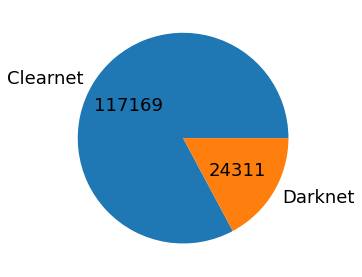

In [32]:
df = samples.groupby("Label").count()
fig, ax = plt.subplots(figsize=(5,5))

df.plot(y="Label.1", legend=None, ax=ax, shadow=False, kind="pie", fontsize=18,autopct=lambda x: int(df["Label.1"].values.sum()*x/100))
plt.ylabel("")
plt.tight_layout()
plt.show()

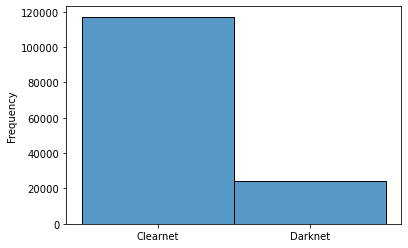

In [33]:
sns.histplot(data=samples, x="Label", stat="frequency")
plt.xlabel('')
plt.show()

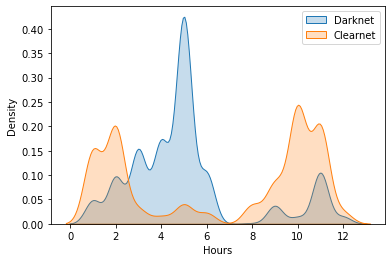

In [37]:
plot_graph_darknet = samples[samples['Label'] == "Darknet"]
plot_graph_Clearnet = samples[samples['Label'] == "Clearnet"]
sns.kdeplot(plot_graph_darknet['hour'], shade=True)
sns.kdeplot(plot_graph_Clearnet['hour'], shade=True)
plt.xlabel("Hours")
plt.ylabel("Density")
plt.legend(['Darknet', 'Clearnet'])
plt.show()

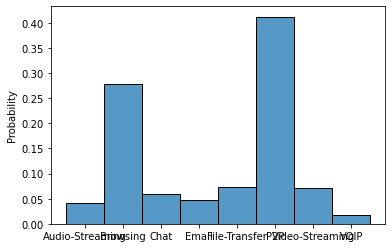

In [35]:
sns.histplot(data=samples[samples['Label'] == "Clearnet"], x="Label.1", stat="probability")
plt.xlabel('')
plt.show()

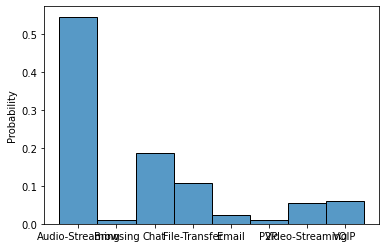

In [36]:
sns.histplot(data=samples[samples['Label'] == "Darknet"], x="Label.1", stat="probability")
plt.xlabel('')
plt.show()